# Unsupervised Machine Learning: Clustering and Dimensionality Reduction

CSC/DSC 340 Week 6 Slides

Author: [Dr. Julie Butler](www.juliebutler.org)

Date Created: August 24, 2023

Last Modified: August 29, 2023

In [1]:
##############################
##          IMPORTS         ##
##############################
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.stats import uniform
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import accuracy_score, classification_report

## Wine Data Set (Classification)
* 178 data points with 13 features and 3 different target values
* Goal: given information about a wine, predict which of three locations it originated from
* Data set challenges: varying scales and clas imbalance

In [2]:
wine = load_wine()
wine_data = pd.DataFrame(data=wine.data, columns=wine.feature_names)
wine_data['labels'] = wine.target
wine_data

alcohol  malic_acid   ash  alcalinity_of_ash  magnesium  total_phenols  \
0      14.23        1.71  2.43               15.6      127.0           2.80   
1      13.20        1.78  2.14               11.2      100.0           2.65   
2      13.16        2.36  2.67               18.6      101.0           2.80   
3      14.37        1.95  2.50               16.8      113.0           3.85   
4      13.24        2.59  2.87               21.0      118.0           2.80   
..       ...         ...   ...                ...        ...            ...   
173    13.71        5.65  2.45               20.5       95.0           1.68   
174    13.40        3.91  2.48               23.0      102.0           1.80   
175    13.27        4.28  2.26               20.0      120.0           1.59   
176    13.17        2.59  2.37               20.0      120.0           1.65   
177    14.13        4.10  2.74               24.5       96.0           2.05   

     flavanoids  nonflavanoid_phenols  proanthocyanins  color_intensity   hue  \
0          3.06                  0.28             2.29             5.64  1.04   
1          2.76                  0.26             1.28             4.38  1.05   
2          3.24                  0.30             2.81             5.68  1.03   
3          3.49                  0.24             2.18             7.80  0.86   
4          2.69                  0.39             1.82             4.32  1.04   
..          ...                   ...              ...              ...   ...   
173        0.61                  0.52             1.06             7.70  0.64   
174        0.75                  0.43             1.41             7.30  0.70   
175        0.69                  0.43             1.35            10.20  0.59   
176        0.68                  0.53             1.46             9.30  0.60   
177        0.76                  0.56             1.35             9.20  0.61   

     od280/od315_of_diluted_wines  proline  labels  
0                            3.92   1065.0       0  
1                            3.40   1050.0       0  
2                            3.17   1185.0       0  
3                            3.45   1480.0       0  
4                            2.93    735.0       0  
..                            ...      ...     ...  
173                          1.74    740.0       2  
174                          1.56    750.0       2  
175                          1.56    835.0       2  
176                          1.62    840.0       2  
177                          1.60    560.0       2  

[178 rows x 14 columns]

/Users/butlerju/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


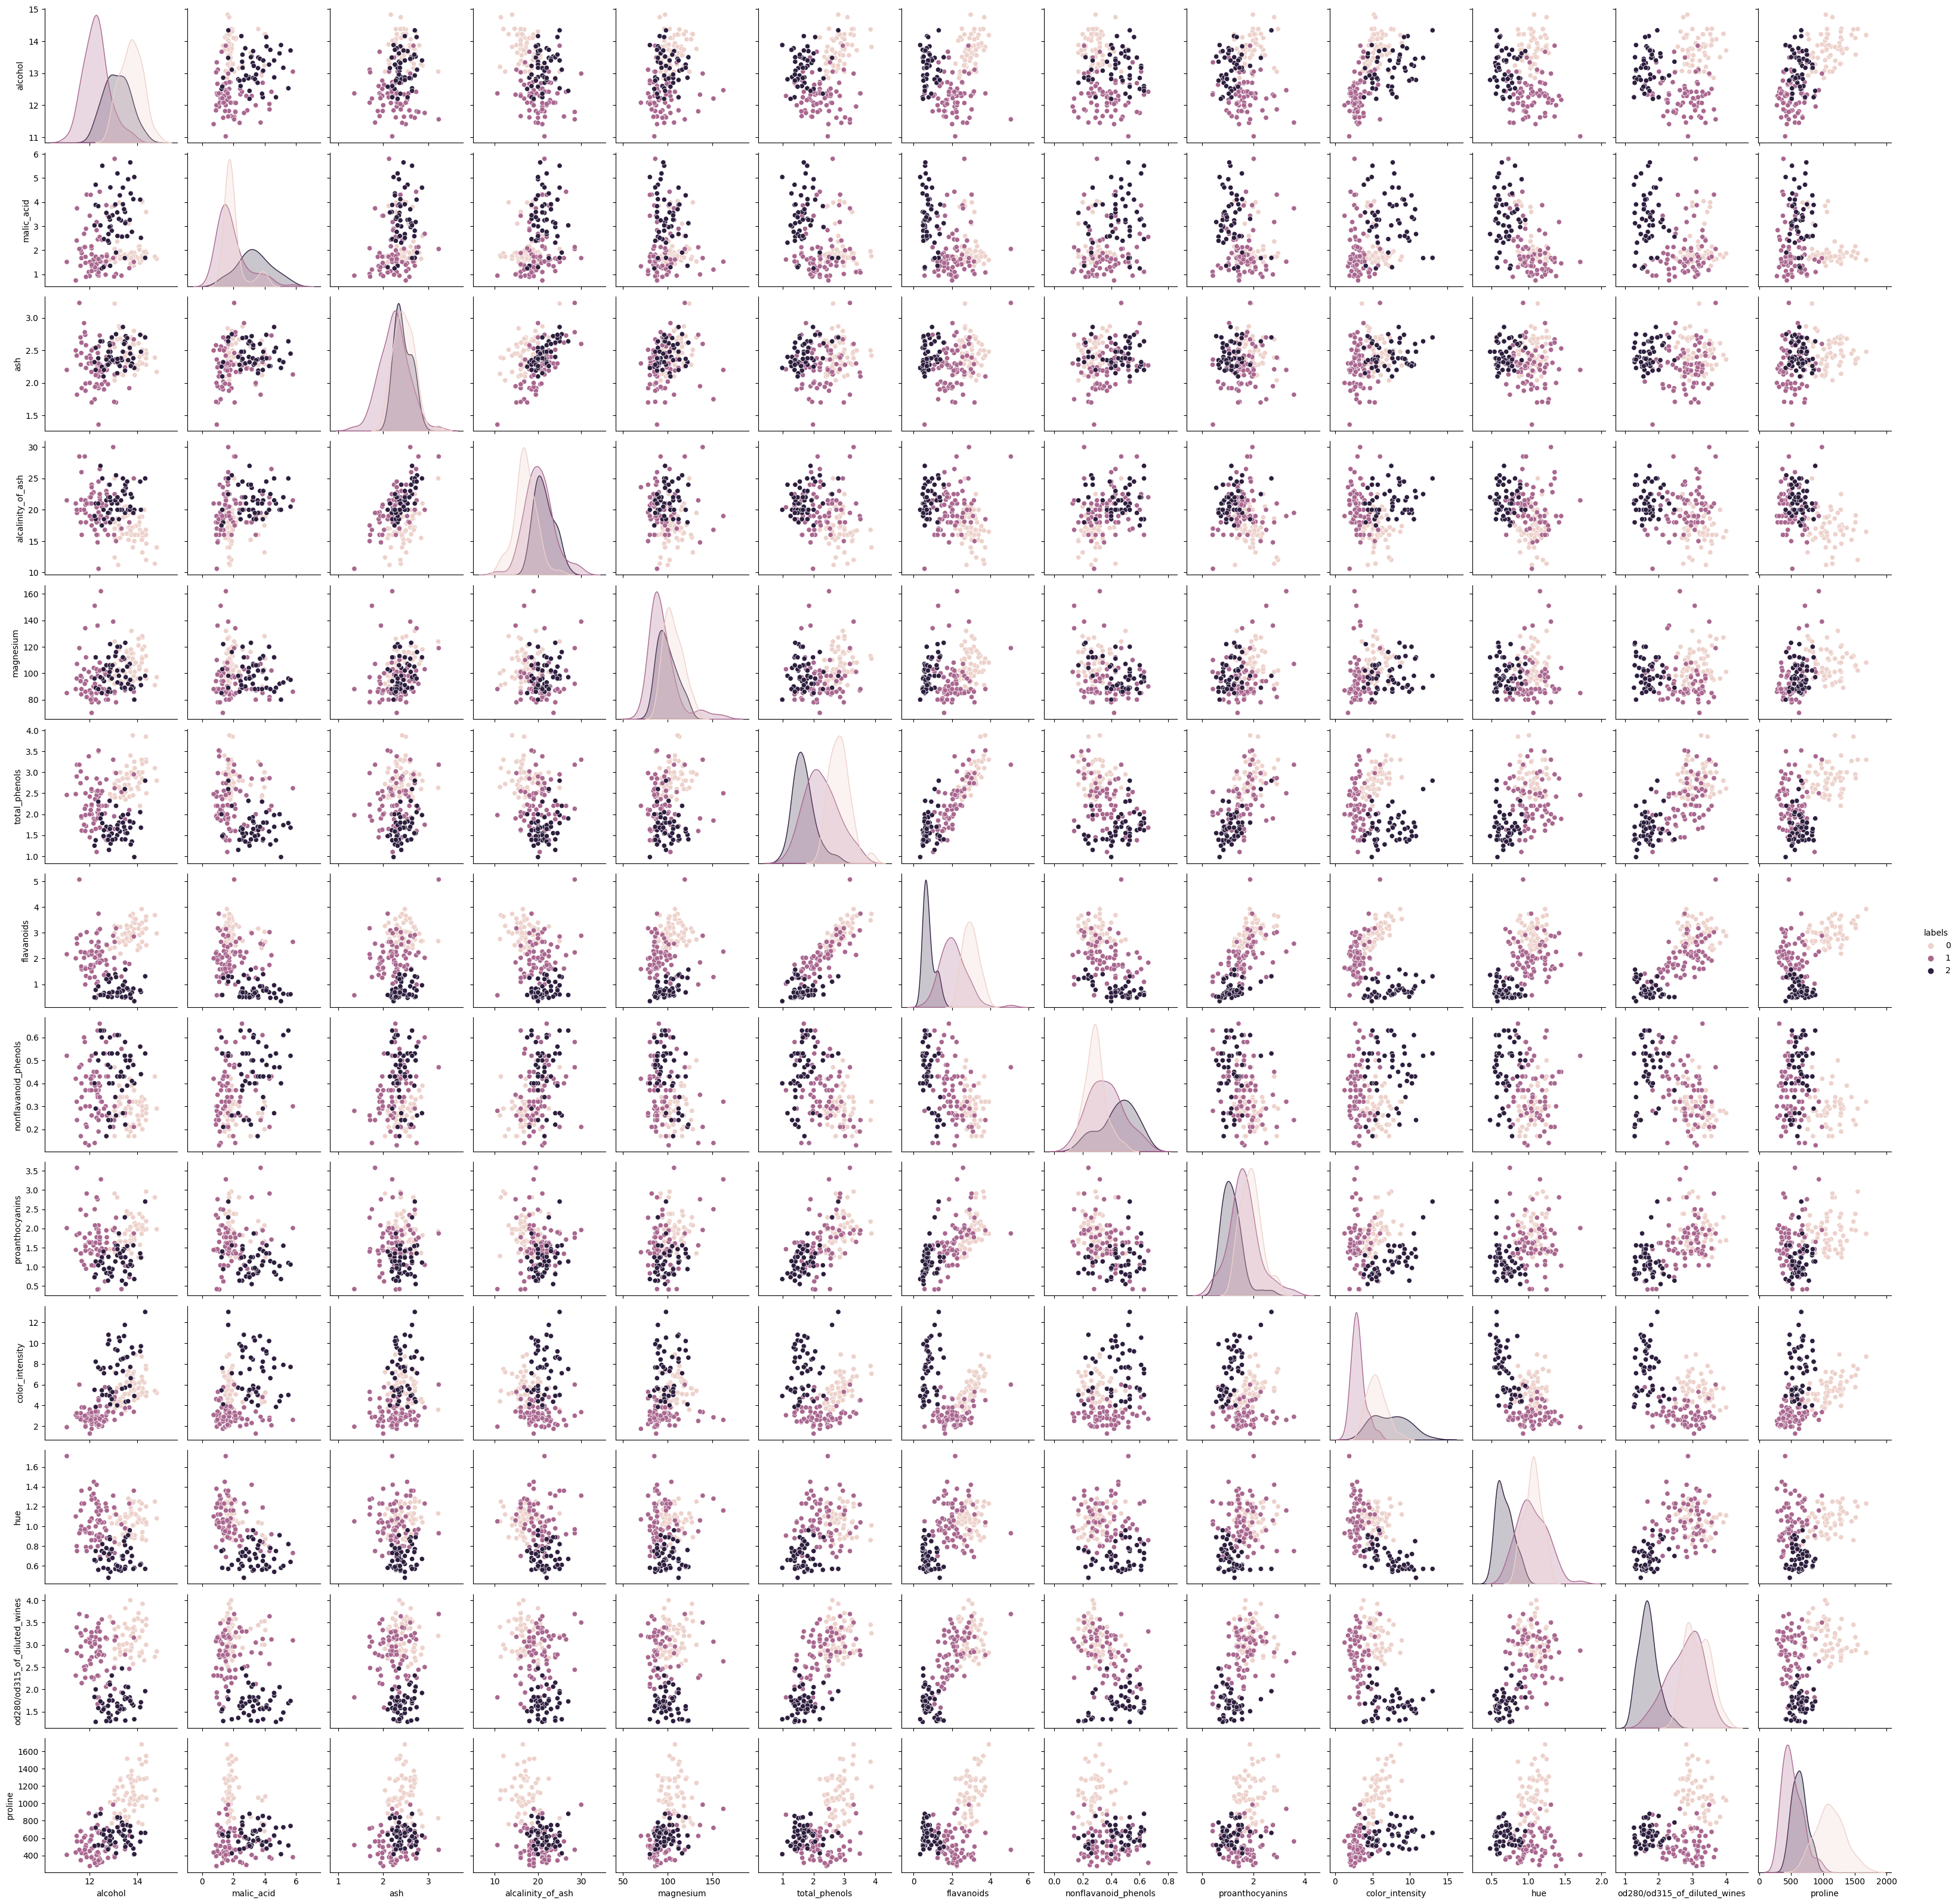

In [3]:
sns.pairplot(wine_data, hue='labels')

### Support Vector Classification
* Binary classifier that finds a hyperplane that separates the two classes of data
* Can be extended to multiclass classification using a One-vs-Rest (OvR) approach
* Also uses the kernel trick (like KRR) to modify the data to better fit nonlinear patterns (can find patterns that ridge classification cannot)

In [1]:
X = np.asarray(wine_data.drop(columns=['labels']))
y = np.asarray(wine_data['labels'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

NameError: name 'np' is not defined

Can attempt to scale the data as well

In [5]:
scaler = StandardScaler()
scaler.fit(X)
Z = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(Z,y,test_size=0.2)

svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


## Clustering

### What is Unsupervised Learning?
* Algorithms learn from unlabeled data (just the feature) with the goal of finding hidden patterns in the data
* Examples of unsupervised learning tasks: clustering, dimensionality reduction, and anomaly detection

### What is Clustering?
* Unsupervised learning technique where data is grouped into clusters based on similarity
* Unsupervised learning version of classification, could be grouped in a workflow with classification
* Algorithms: **k-Means**, heirarchical clustering analysis (HCA), DBSCAN

### k-Means (KMeans)
* Used for partitioning data into clusters based on similarities in the data points

### How does k-means work?
1. Initialize the cluster centroids
2. Assign each data point to the closest centroid
3. Update the centroids to the center of each cluster
4. Repeat until convergence

![kmeans](https://media.licdn.com/dms/image/C5612AQH8kEizAouznA/article-cover_image-shrink_600_2000/0/1626424726069?e=2147483647&v=beta&t=deUL_yPDFPXK8dkspX2oJZWX1qqyx3XBokl02TN8x9k)

### Measure of Success
* Within-Cluster Sum of Squares (WCSS) or Interia
    * The sum of the squared distances between each data point and the centroid of its cluster
    * Measure of the compactness of each cluster

#### Assuming We Know the Number of Clusters

In [6]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init='auto')

# Fit the KMeans model
kmeans.fit(X)

# Predict the clusters
cluster_labels = kmeans.labels_

#### Plot the predicted clusters

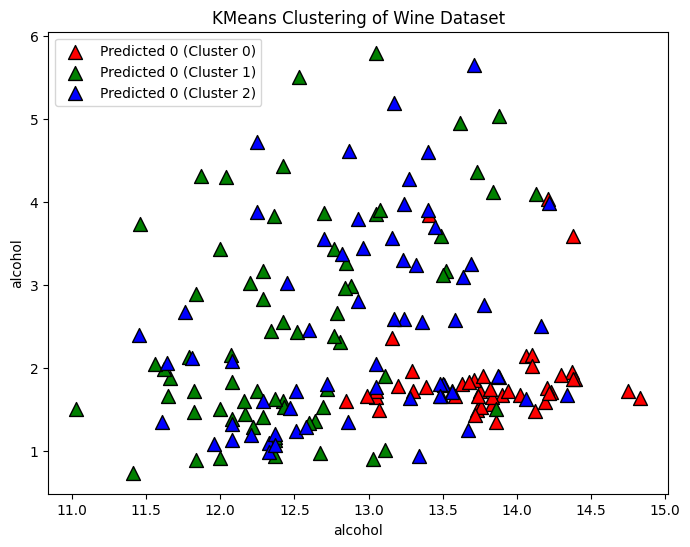

In [7]:
# Plot the clusters
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_clusters), ['r', 'g', 'b']):
    predicted_indices = np.where(cluster_labels == i)
    plt.scatter(X[predicted_indices, 0], X[predicted_indices, 1], c=color, label=f'Predicted {y[i]} (Cluster {i})', marker='^', edgecolors='k', s=100)

plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[0])
plt.title('KMeans Clustering of Wine Dataset')
plt.legend()

#### Compare to the True Clusters
* There is no error score or accuracy score because the algorithm is learning from unlabeled data

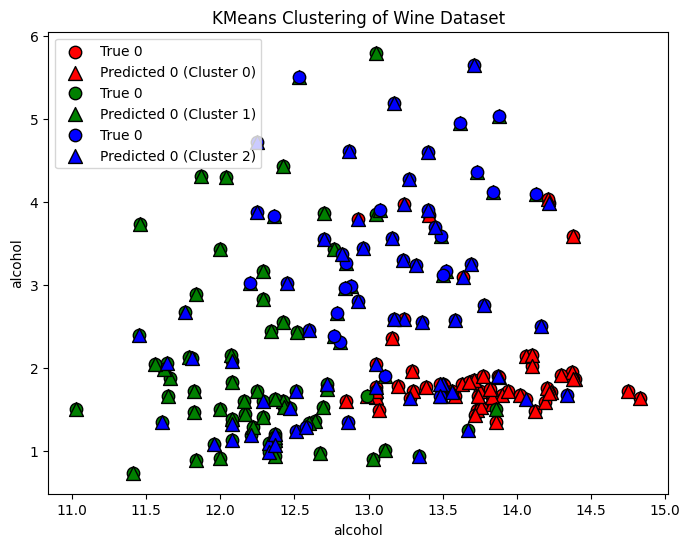

In [8]:
# Plot the clusters
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_clusters), ['r', 'g', 'b']):
    true_indices = np.where(y == i)
    predicted_indices = np.where(cluster_labels == i)
    plt.scatter(X[true_indices, 0], X[true_indices, 1], c=color, label=f'True {y[i]}',  edgecolors='k', s=80)
    plt.scatter(X[predicted_indices, 0], X[predicted_indices, 1], c=color, label=f'Predicted {y[i]} (Cluster {i})', marker='^', edgecolors='k', s=100)

plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[0])
plt.title('KMeans Clustering of Wine Dataset')
plt.legend()
plt.show()

#### Does Scaled Data Improve Accuracy?

In [9]:
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, n_init='auto')

# Fit the KMeans model
kmeans.fit(Z)

# Predict the clusters
cluster_labels = kmeans.labels_

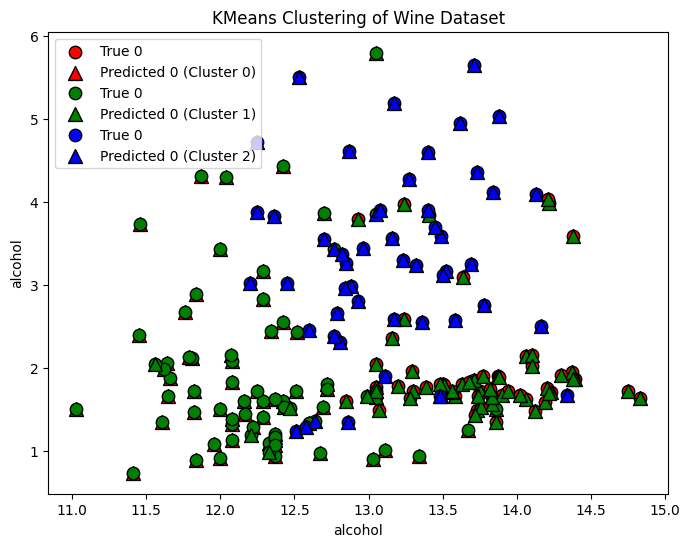

In [10]:
# Plot the clusters
plt.figure(figsize=(8, 6))
for i, color in zip(range(n_clusters), ['r', 'g', 'b']):
    true_indices = np.where(y == i)
    predicted_indices = np.where(cluster_labels == i)
    plt.scatter(X[true_indices, 0], X[true_indices, 1], c=color, label=f'True {y[i]}', edgecolors='k', s=80)
    plt.scatter(X[predicted_indices, 0], X[predicted_indices, 1], c=color, label=f'Predicted {y[i]} (Cluster {i})', marker='^', edgecolors='k', s=100)

plt.xlabel(wine.feature_names[0])
plt.ylabel(wine.feature_names[0])
plt.title('KMeans Clustering of Wine Dataset')
plt.legend()
plt.show()

#### What is We Do Not Know the Number of Clusters?

Method 1: Elbow Plot
* Plot of WCSS vs. the number of clusters
* Identify the "elbow", the point at which the reduction in WCSS starts to slow down

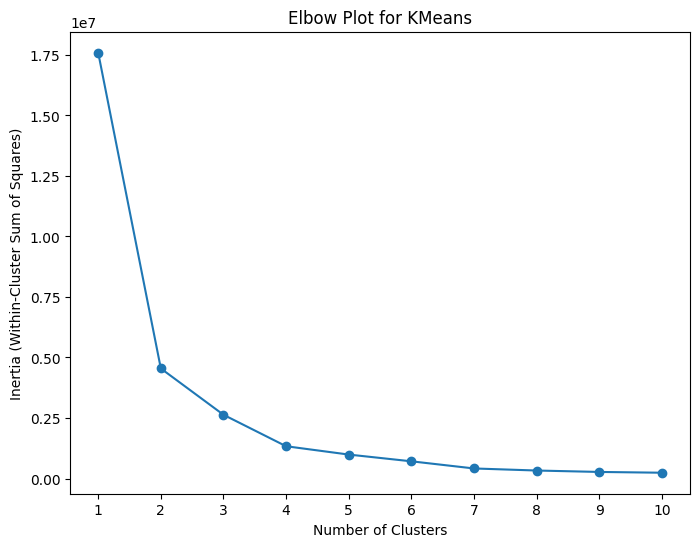

In [11]:
# Calculate within-cluster sum of squares for different numbers of clusters
inertia_values = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Plot for KMeans')
plt.xticks(np.arange(1, 11))
plt.show()

We can also plot the difference in inertia values to see if this gives a clearer picture.

Text(0, 0.5, 'Inertia(i+1) - Inertia(i)')

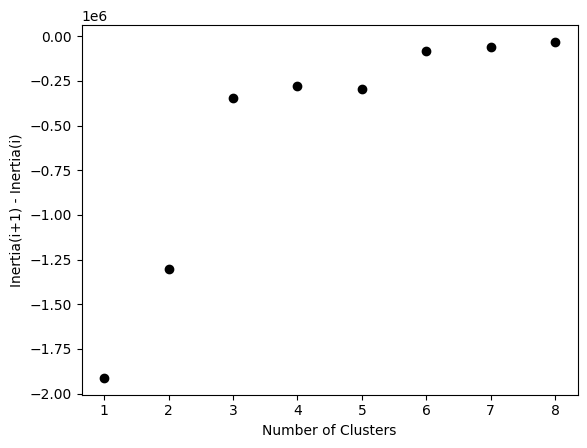

In [12]:
for i in range(1,9):
    plt.scatter(i, inertia_values[i+1]-inertia_values[i], color='k')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia(i+1) - Inertia(i)")

Method 2: Silhouette Scores
* Measure of how well-separated and distinct the clusters are
    * Close to +1 means well clustered with a clear separation between clusters
    * Close to 0 means overlapping and crowded clusters
    * Close to -1 means data points may have been misclassified

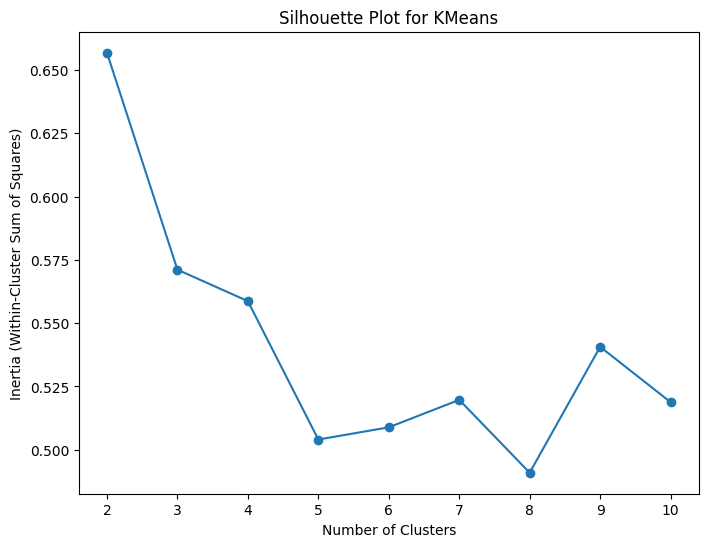

In [13]:
# Calculate within-cluster sum of squares for different numbers of clusters
silhouette_values = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
    kmeans.fit(X)
    silhouette_values.append(silhouette_score(X, kmeans.labels_))

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Silhouette Plot for KMeans')
plt.show()

* Need to set initialization and convergence criteria for Kmeans algorithms
    * Scikit-Learn does provide defaults
    * Random initialization: initial centroids are randomly placed, can suffer from poor convergence
    * KMeans++ selectric centroids more intelligently with probability

* Challenges of KMeans: sensitivity to initialization, handling outliers, determining the optimal number of clusters

## Dimensionality Reduction
* Reducing the number of dimensions in the data set while preserving the essential information needed to train a model
* High dimensional data can lead to overfitting, increased complexity, and computational effeciencies
* Two main ways to reduce dimensions: feature selection selects a subset of original features, while feature extraction creates new features
* General machine learning workflow will involve peformin dimensionality reduction of the features of the data set (unsupervised learning) and the using those reduced features and the data set labels to train a classification or regression model (supervised learning)

### Principal Component Analysis (PCA)
* A dimensionality reduction technique used to transform high-dimensional data into lower-dimensional data while retaining as much variance as possible
* Benefits: reduced noise and complexity, improved visualization and computational effiecency

#### How does PCA Work?
1. Standardize the data (data **must** be standardized for PCA)
2. Calculate the covariance matrix
    * Covariance matrix: each elements represents the covariance between two variables
    * Covariance is a measure of how two variables change together
3. Calculate the eigenvectors and eigenvalues of the covariance matrix
4. Select principal components based on eigenvalues
    * largest eigenvalye of the covariance matrix has the eigenvector (principal component) that captures the most variance
5. Transform the data to lower dimension
    * Create a transformation matrix where the principal components are the columns and multiply the transformation matrix by the original data. This is a projection.

## Interpretability and Challenges
* The principal components can be interpreted as linear combinations of the original features **but** tthey have no direct physical meaning
* Limitations
    * Dimensionality reduction can lead to a potential loss of information
    * Complex relationships in the data may not be perserved
    * The data set has to be scaled before applying PCA
    * PCA works best when there are correlations between the features

To start with, let's attempt to reduce the number of features in our wine data set from 6 to 13. Even with just this initial guess in the number of principal components, we should be an improvement in th accuracy score.

In [14]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=6)  # Choose the number of principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize the Support Vector Classifier
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVC on the PCA-transformed training data
svc.fit(X_train_pca, y_train)

# Predict the classes on the PCA-transformed test data
y_pred = svc.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


Next we need to determine what the best number of components is in our model.  We can think of this as hyperparameter tuning (like we covered last week). The first method we can try is to use a basic for loop and iterate over the possible number of principal components and test the accuracy at each new value. We can then train the model using the PCA results from the best number of components.

In [15]:
for i in range(1,13):
    # Perform PCA for dimensionality reduction
    pca = PCA(n_components=i)  # Choose the number of principal components
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Initialize the Support Vector Classifier
    svc = SVC(kernel='linear', C=1.0, random_state=42)
    
    # Train the SVC on the PCA-transformed training data
    svc.fit(X_train_pca, y_train)
    
    # Predict the classes on the PCA-transformed test data
    y_pred = svc.predict(X_test_pca)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Number of Components:", i, f"Accuracy: {accuracy:.2f}")

Number of Components: 1 Accuracy: 0.78
Number of Components: 2 Accuracy: 0.94
Number of Components: 3 Accuracy: 0.94
Number of Components: 4 Accuracy: 0.94
Number of Components: 5 Accuracy: 0.94
Number of Components: 6 Accuracy: 0.92
Number of Components: 7 Accuracy: 0.92
Number of Components: 8 Accuracy: 0.92
Number of Components: 9 Accuracy: 0.92
Number of Components: 10 Accuracy: 0.92
Number of Components: 11 Accuracy: 0.92
Number of Components: 12 Accuracy: 0.92


In [16]:
pca = PCA(n_components=7)  # Choose the number of principal components
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize the Support Vector Classifier
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVC on the PCA-transformed training data
svc.fit(X_train_pca, y_train)

# Predict the classes on the PCA-transformed test data
y_pred = svc.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.92


Instead of just doing the for loop method for finding the best number of components, you can also use GridSearchCV and RandomizedSearchCV as well.  Additionally, by making use of the `Pipeline` feature from Scikit-Learn, you can tune both your PCA and your machine learning model simultaneously. Here we use `Pipeline` to link the standard scaler, PCA, and the support vector classifier together and then use `RandomizedSearchCV` to tune the number of PCA components and two hyperparameters from the support vector classifier.

In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

# Create a pipeline with PCA and SVC
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('svc', SVC())
])

# Define parameter distributions for RandomizedSearchCV
param_dist = {
    'pca__n_components': [2, 5, 8],  # Number of principal components
    'svc__C': uniform(0.1, 10),       # Regularization parameter C
    'svc__kernel': ['linear', 'rbf'], # Kernel type
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=100)

# Fit the RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Predict the classes on the test data
y_pred = random_search.predict(X_test)

# Calculate accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")


Best Hyperparameters: {'pca__n_components': 5, 'svc__C': 0.8905117050108512, 'svc__kernel': 'linear'}
Accuracy: 1.00


Finally, instead of passing the PCA algorithm the number of components you want, you can instead pass it a number between 0.0 and 1.0 (exclusive). This number correpsonds to the amount of variance in the data you wish to preserve.  The more variance kept the greater the differentiation among the data will be, but likely the more components that will be needed as well.

In [20]:
pca = PCA(n_components=0.95)  # Choose the variance
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components:", pca.n_components_)

# Initialize the Support Vector Classifier
svc = SVC(kernel='linear', C=1.0, random_state=42)

# Train the SVC on the PCA-transformed training data
svc.fit(X_train_pca, y_train)

# Predict the classes on the PCA-transformed test data
y_pred = svc.predict(X_test_pca)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Number of PCA Components: 10
Accuracy: 0.94


Text(0, 0.5, 'See Legend')

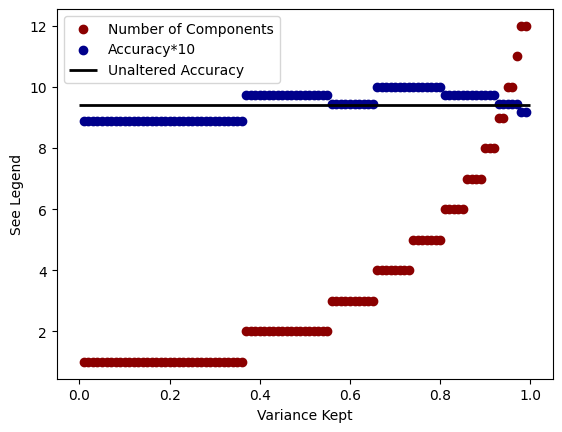

In [21]:
for i in range(1,100):
    i /= 100

    pca = PCA(n_components=i)  # Choose the number of principal components
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    plt.scatter(i,pca.n_components_, color='darkred', label='Number of Components'if i == 0.99 else "_nolegend_")

    # Initialize the Support Vector Classifier
    svc = SVC(kernel='linear', C=1.0, random_state=42)
    
    # Train the SVC on the PCA-transformed training data
    svc.fit(X_train_pca, y_train)
    
    # Predict the classes on the PCA-transformed test data
    y_pred = svc.predict(X_test_pca)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    plt.scatter(i,accuracy*10, color='darkblue', label='Accuracy*10'if i == 0.99 else "_nolegend_")

plt.hlines(9.4, 0.0, 1.0, linewidth=2, color='k', label="Unaltered Accuracy")
plt.legend()
plt.xlabel("Variance Kept")
plt.ylabel("See Legend")

PCA may not seem very useful for the data sets we encounter in this class, but many real world data sets can have hundreds or thousands of different features, and not all of them will be relevant.